In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from utils import *
from ADMM import *

In [2]:
data_dir = '../datasets/PEMS0X_data'
# TODO: change here
dataset = 'PEMS04'
data_folder = os.path.join(data_dir, dataset)
data_file = dataset + '.npz'
graph_csv = dataset + '.csv'
# data
traffic_dataset = TrafficDataset(data_folder, data_file, graph_csv)
print(f"data shape: {traffic_dataset.data.shape}, node number: {traffic_dataset.graph_info['n_nodes']}, edge number: {traffic_dataset.graph_info['n_edges']}")

# kNNs and graph construction
k = 4
nearest_nodes, nearest_dists = k_nearest_neighbors(traffic_dataset.graph_info['n_nodes'], traffic_dataset.graph_info['u_edges'], traffic_dataset.graph_info['u_dist'], k)
print(f'nearest nodes: {nearest_nodes.shape}, nearest_dists: {nearest_dists.shape}')

# mixed_graph_from_distance()

x, y = traffic_dataset.get_data(0)
print(f'training shape: x: {x.shape}, y: {y.shape}')

data shape: torch.Size([16992, 307, 1]), node number: 307, edge number: 340
307 nodes, 4 neighbors
nearest nodes: torch.Size([307, 5]), nearest_dists: torch.Size([307, 5])
training shape: x: torch.Size([24, 307, 1]), y: torch.Size([12, 307, 1])


In [3]:
# test primal guess
x, y = x.unsqueeze(0), y.unsqueeze(0)
print(x.dtype, y.dtype)
print(torch.arange(0,12).dtype)
x_init = initial_guess(y, 12, 24)
print(x_init.shape)

torch.float64 torch.float64
torch.int64
torch.float32
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
torch.Size([1, 24, 307, 1])


torch.Size([24, 10])
torch.Size([24])


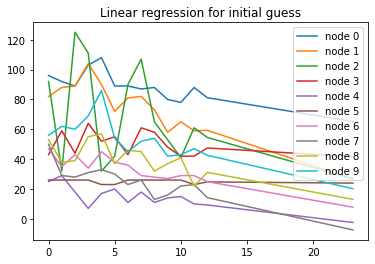

In [4]:
# plot primal guess
from matplotlib import pyplot as plt

x_top = x_init[:,:,0:10].squeeze()
print(x_top.shape)
t = torch.arange(0,24,1)
print(t.shape)
plt.figure()
plt.plot(t, x_top)
plt.legend([f'node {i}' for i in range(10)])
plt.title('Linear regression for initial guess')
plt.show()

In [37]:
# test CG solver

A = torch.ones((6, 6))#  + torch.diag_embed(torch.ones(6))
def Ax(x):
    B, T, N, C = x.size()
    x = x.reshape(B, -1, C)
    # print('x',x.reshape(-1), 'Ax', A @ x.reshape(-1))
    return torch.einsum('ij, bjc -> bic', A, x).reshape(B, T, N, C)

def Atx(x):
    B, T, N, C = x.size()
    x = x.reshape(B, -1, C)
    # print('x',x.reshape(-1), 'Ax', A @ x.reshape(-1))
    return torch.einsum('ij, bjc -> bic', A.T, x).reshape(B, T, N, C)

def CG_solver(LHS_func, RHS, x0=None, At_func=None):
    '''
    Solving linear systems LHS_func(x) = RHS, B samples at the same time
    Input:
        x0 in (B, T, N, n_channels)
        LHS_func(x, args) in (B, T, N, n_channels)
        RHS in (B, T, N, n_channels)
    '''
    has_solution = True
    alpha_list = []
    beta_list = []
    if x0 is None:
        x = torch.zeros_like(RHS)
    else:
        x = x0.clone()
    
    r = RHS - LHS_func(x)
    p = r.clone() # in (B, T, N, C)

    r_norm_sq = (r * r).sum([1,2]) # in (B,)
    # print(f'initial error {torch.sqrt(r_norm_sq)}')
    for k in range(100):
        Ap = LHS_func(p)
        # print('p', p.squeeze(), 'Ap', Ap.squeeze())
        alpha = r_norm_sq / (p * Ap).sum([1,2]) # in (B,)
        if alpha.max() > 1e6:
            print(f'no solution, Ap = {alpha.max()}, compute least square solution')
            print(f'at this time x = {x.squeeze()}, real error = {torch.abs(LHS_func(x) - RHS).max():.4f}')
            has_solution = False
            break
        alpha_list.append(alpha)
        x = x + alpha[:, None, None, :] * p
        r = r - alpha[:, None, None, :] * Ap

        r_norm_new_sq = (r * r).sum([1,2]) # in (B,)
        beta = r_norm_new_sq / r_norm_sq
        beta_list.append(beta)

        print(f"CG iteration {k}: real error {torch.abs(LHS_func(x) - RHS).max():.4f}, total max error {torch.sqrt(r_norm_new_sq).max():.4g}, alpha in ({alpha.min():.4g}, {alpha.max():.4g}), beta in ({beta.min():.4g}, {beta.max():.4g})")

        if torch.sqrt(r_norm_new_sq).max() < 1e-8:
            print(f'{k+1} CG iterations')
            return x, k + 1, torch.Tensor(alpha_list), torch.Tensor(beta_list) # iterations
        

        p = r + beta[:, None, None, :] * p
        r_norm_sq = r_norm_new_sq
    
    if not has_solution:
        def AtA_func(x):
            return At_func(LHS_func(x))
        return CG_solver(AtA_func, At_func(RHS), x0)
        # return None

    return x, 100, alpha_list, beta_list

RHS = torch.Tensor([[2,2,2,3,3,3]]).reshape(1, 2, 3, 1).to(torch.float)
x, iters, alphas, betas = CG_solver(Ax, RHS, RHS, At_func=Atx)
print(x)



CG iteration 0: real error 0.5200, total max error 1.226, alpha in (0.1669, 0.1669), beta in (0.0016, 0.0016)
no solution, Ap = 183545118720.0, compute least square solution
at this time x = tensor([[-0.1701, -0.1701, -0.1701],
        [ 0.9968,  0.9968,  0.9968]]), real error = 0.5200
CG iteration 0: real error 0.0000, total max error 0, alpha in (0.02778, 0.02778), beta in (0, 0)
1 CG iterations
tensor([[[[-0.0833],
          [-0.0833],
          [-0.0833]],

         [[ 0.9167],
          [ 0.9167],
          [ 0.9167]]]])


In [5]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init,
    'rho_u': rho_init,
    'rho_d': rho_init,
    'mu_u': 3,
    'mu_d1':3,
    'mu_d2': 3
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=20,
                            d_sigma=20,
                            )

rho_init: 3.5765439556458225
307 nodes, 4 neighbors


In [ ]:
# test ADMM algorithm
